In [ ]:
pip install gensim

   ---------------------------------------- 0.0/24.4 MB ? eta -:--:--
   --- ------------------------------------ 2.1/24.4 MB 10.1 MB/s eta 0:00:03
   ---------- ----------------------------- 6.3/24.4 MB 16.4 MB/s eta 0:00:02
   ----------------- ---------------------- 10.7/24.4 MB 19.2 MB/s eta 0:00:01
   -------------------------------- ------- 19.9/24.4 MB 24.7 MB/s eta 0:00:01
   --------------------------------- ------ 20.4/24.4 MB 20.7 MB/s eta 0:00:01
   ---------------------------------------- 24.4/24.4 MB 20.5 MB/s eta 0:00:00

   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   -------------------- ------------------- 1/2 [gensim]
   ---------------------------------------- 2/2 [gensim]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gensim.downloader as api

print(">>> Pre-trained 모델(GloVe) 다운로드 중... (약 130MB, 1~2분 소요)")
# 'word2vec-google-news-300'은 성능은 좋지만 용량이 1.6GB로 커서 Colab에서 자주 튕깁니다.
# 대신 가볍고 성능 좋은 GloVe 모델을 사용합니다.
pretrained_model = api.load("glove-wiki-gigaword-100")

print(f"✅ 모델 로드 완료! 벡터 차원 수: {pretrained_model.vector_size}")
# 테스트
print(f"- 'movie'와 유사한 단어: {pretrained_model.most_similar('movie', topn=3)}")

>>> Pre-trained 모델(GloVe) 다운로드 중... (약 130MB, 1~2분 소요)
[==================================================] 100.0% 128.1/128.1MB downloaded
✅ 모델 로드 완료! 벡터 차원 수: 100
- 'movie'와 유사한 단어: [('film', 0.9055121541023254), ('movies', 0.8959326148033142), ('films', 0.866355299949646)]


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# 경고 메시지 무시 (깔끔한 출력을 위해)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
from pathlib import Path

BASE_DIR = Path('data')

TAGS_PATH = BASE_DIR / 'tags_processed.csv'
MOVIES_PATH = BASE_DIR / 'movies_processed.csv'

print(f"📂 설정된 태그 파일 경로: {TAGS_PATH}")
try:
    # pathlib 객체를 read_csv에 바로 넣어도 잘 작동합니다.
    tags = pd.read_csv(TAGS_PATH)
    movies = pd.read_csv(MOVIES_PATH)

    print("✅ 데이터 로드 성공!")
    print(f"- 태그 데이터: {tags.shape} rows")
    print(f"- 영화 데이터: {movies.shape} rows")

    display(tags.head(3))

except FileNotFoundError as e:
    print(f"❌ 파일을 찾을 수 없습니다. 아래 경로가 실제로 존재하는지 확인해주세요.")
    print(f"확인 경로: {TAGS_PATH}")
    # Colab에서는 좌측 폴더 아이콘을 눌러 실제 경로가 맞는지 눈으로 확인하는 것이 좋습니다.

📂 설정된 태그 파일 경로: data\tags_processed.csv
✅ 데이터 로드 성공!
- 태그 데이터: (3683, 4) rows
- 영화 데이터: (9703, 3) rows


,user_id,movie_id,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# NLTK 설정
nltk.download('stopwords', quiet=True)
stops = set(stopwords.words('english'))

# 수정된 전처리 함수 (Stemming 제거!)
def preprocess_for_w2v(text):
    if not isinstance(text, str): return ''

    # 1. 소문자 변환
    text = text.lower()

    # 2. 특수문자 처리 (sci-fi -> scifi 보존)
    text = text.replace('-', '')
    text = re.sub(r'[^a-z0-9\s]', ' ', text)

    # 3. 불용어 제거만 수행 (Stemming X)
    # 모델이 단어 원형을 인식할 수 있도록 그대로 둡니다.
    words = text.split()
    meaningful_words = [w for w in words if w not in stops]

    return ' '.join(meaningful_words)

print(">>> 태그 정제 중 (Stemming 제외)...")
tags['clean_tag'] = tags['tag'].apply(preprocess_for_w2v)

# 빈 태그 제거
tags = tags[tags['clean_tag'] != '']

print(f"✅ 전처리 완료. 남은 태그 데이터 수: {len(tags)}")

# 확인 사살: 단어가 잘리지 않았는지 확인
print(f"예시 확인: {tags['clean_tag'].head()}")

>>> 태그 정제 중 (Stemming 제외)...
✅ 전처리 완료. 남은 태그 데이터 수: 3683
예시 확인: 0              funny
1    highly quotable
2            ferrell
3       boxing story
4                mma
Name: clean_tag, dtype: object


In [ ]:
tags.shape

(3683, 5)

In [ ]:
tags.head()

,user_id,movie_id,tag,timestamp,clean_tag
0,2,60756,funny,1445714994,funny
1,2,60756,Highly quotable,1445714996,highly quotable
2,2,60756,will ferrell,1445714992,ferrell
3,2,89774,Boxing story,1445715207,boxing story
4,2,89774,MMA,1445715200,mma


In [ ]:
# 1. 태그 데이터에 존재하는 영화 ID 목록 추출 (중복 제거)
tagged_movie_ids = tags['movie_id'].unique()

# 2. 전체 영화 중에서 태그 보유 여부 확인
# isin(): 리스트 안에 값이 있으면 True, 없으면 False 반환
has_tags = movies['movie_id'].isin(tagged_movie_ids)

# 3. 개수 계산
count_with_tags = has_tags.sum()       # True(태그 있음) 개수
count_no_tags = (~has_tags).sum()      # False(태그 없음) 개수
total_movies = len(movies)

# 4. 결과 출력
print(f"📊 전체 영화 데이터 분석 결과")
print(f"-" * 30)
print(f"1. 전체 영화 수      : {total_movies:,}개")
print(f"2. 태그가 있는 영화  : {count_with_tags:,}개 ({count_with_tags/total_movies*100:.1f}%)")
print(f"3. 태그가 없는 영화  : {count_no_tags:,}개 ({count_no_tags/total_movies*100:.1f}%)")

# 5. 태그 없는 영화 샘플 확인
print(f"-" * 30)
print(">>> 태그가 없는 영화 샘플 (Top 5):")
display(movies[~has_tags].head(5))

📊 전체 영화 데이터 분석 결과
------------------------------
1. 전체 영화 수      : 9,703개
2. 태그가 있는 영화  : 1,569개 (16.2%)
3. 태그가 없는 영화  : 8,134개 (83.8%)
------------------------------
>>> 태그가 없는 영화 샘플 (Top 5):


,movie_id,title,genres
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,6,Heat (1995),Action|Crime|Thriller
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [ ]:
# 4. 영화별 태그 합치기 (Grouping)
# 한 영화에 달린 여러 태그를 하나의 긴 문장(Document)으로 만듭니다.
tags_grouped = tags.groupby('movie_id')['clean_tag'].apply(lambda x: ' '.join(x)).reset_index()

In [ ]:
tags_grouped.head()
tags_grouped.shape



(1572, 2)

In [ ]:
# 영화 제목과 병합 (태그가 있는 영화만 남음)
df_movies_with_tags = pd.merge(movies, tags_grouped, on='movie_id', how='inner')
print(df_movies_with_tags.shape)

(1569, 4)


In [ ]:
df_movies_with_tags.head()

,movie_id,title,genres,clean_tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar pixar fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy magic board game robin williams game
2,3,Grumpier Old Men (1995),Comedy|Romance,moldy old
3,5,Father of the Bride Part II (1995),Comedy,pregnancy remake
4,7,Sabrina (1995),Comedy|Romance,remake


### 6. 영화 태그 벡터화 (Word2Vec 활용)

Word2Vec 모델을 사용하여 각 영화의 `clean_tag`를 벡터로 변환합니다. 여기서는 이미 로드해둔 'glove-wiki-gigaword-100' 모델을 활용합니다.

각 영화의 태그 문장을 구성하는 단어들의 벡터를 평균하여 해당 영화의 대표 태그 벡터를 생성합니다.

In [ ]:
def get_tag_vector(tag_string):
    if not isinstance(tag_string, str): # 문자열이 아닌 경우 빈 배열 반환
        return np.zeros(pretrained_model.vector_size)

    words = tag_string.split()
    # 모델에 존재하는 단어들만 필터링하여 벡터를 가져옵니다.
    # 만약 단어가 모델에 없으면 무시합니다.
    word_vectors = [pretrained_model[word] for word in words if word in pretrained_model.key_to_index]

    if not word_vectors:
        # 모든 단어가 모델에 없거나 태그가 비어있으면 0 벡터 반환
        return np.zeros(pretrained_model.vector_size)
    else:
        # 단어 벡터들의 평균을 계산하여 태그 벡터를 생성
        return np.mean(word_vectors, axis=0)

print(">>> 영화 태그 벡터화 진행 중...")
# 각 영화의 clean_tag에 대해 벡터를 생성하여 새로운 컬럼 'tag_vector'에 저장
df_movies_with_tags['tag_vector'] = df_movies_with_tags['clean_tag'].apply(get_tag_vector)

print("✅ 벡터화 완료!")
print(f"생성된 벡터의 차원: {df_movies_with_tags['tag_vector'].iloc[0].shape[0]}")

display(df_movies_with_tags[['movie_id', 'title', 'clean_tag', 'tag_vector']].head())
print(df_movies_with_tags.shape)

>>> 영화 태그 벡터화 진행 중...
✅ 벡터화 완료!
생성된 벡터의 차원: 100


,movie_id,title,clean_tag,tag_vector
0,1,Toy Story (1995),pixar pixar fun,"[0.29658332, -0.14152567, 0.46297336, -0.24183..."
1,2,Jumanji (1995),fantasy magic board game robin williams game,"[0.17696401, 0.01082229, 0.61575794, -0.545457..."
2,3,Grumpier Old Men (1995),moldy old,"[0.26735002, 0.396195, 0.50902, -0.718365, -0...."
3,5,Father of the Bride Part II (1995),pregnancy remake,"[0.227505, -0.368885, 0.32163, -0.06542, -0.35..."
4,7,Sabrina (1995),remake,"[0.03049, -0.55254, 0.95718, -0.44784, 0.34313..."


(1569, 5)


### 7. `tag_vector` 데이터프레임 생성 및 인덱싱

`movieId`를 인덱스로 하고 `tag_vector`의 각 요소를 개별 열로 가지는 새로운 데이터프레임을 생성합니다. 이렇게 하면 각 영화의 태그 벡터를 독립적인 피처로 활용하기 편리합니다.

In [ ]:
# 1. movieId와 tag_vector 컬럼만 선택하여 새로운 DataFrame 생성
df_tag_vectors = df_movies_with_tags[['title', 'tag_vector']].copy()

# 2. movieId를 인덱스로 설정
df_tag_vectors.set_index('title', inplace=True)

# 3. tag_vector 컬럼을 각 벡터 요소별로 분리하여 새로운 컬럼으로 확장
# numpy 배열을 리스트로 변환하여 pd.DataFrame 생성자에 전달
expanded_vectors = pd.DataFrame(df_tag_vectors['tag_vector'].tolist(), index=df_tag_vectors.index)

# 4. 컬럼명 설정 (예: 'vector_0', 'vector_1', ...)
expanded_vectors.columns = [f'vector_{i}' for i in range(expanded_vectors.shape[1])]

# 5. 최종 데이터프레임 확인
df_movie_vectors = expanded_vectors

print("✅ tag_vector만을 저장하는 데이터프레임 생성 완료!")
print(f"생성된 데이터프레임의 형태: {df_movie_vectors.shape}")
display(df_movie_vectors.head())

✅ tag_vector만을 저장하는 데이터프레임 생성 완료!
생성된 데이터프레임의 형태: (1569, 100)


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_90,vector_91,vector_92,vector_93,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.296583,-0.141526,0.462973,-0.241832,0.396610,-0.538187,0.162816,-0.334650,-0.017481,-0.227641,...,0.043673,0.086238,0.418897,-0.237173,-0.045522,-0.487710,-0.03396,-0.050553,0.585613,0.021267
Jumanji (1995),0.176964,0.010822,0.615758,-0.545457,-0.104384,0.398352,0.527116,0.067544,-0.544587,-0.387166,...,-0.205514,0.075601,-0.052046,0.159010,-0.044287,-0.123684,-0.37922,-0.021683,0.329591,-0.076004
Grumpier Old Men (1995),0.267350,0.396195,0.509020,-0.718365,-0.266935,0.229736,0.117022,-0.182472,0.421590,0.818880,...,0.041786,-0.112099,0.047794,0.046825,-0.495976,-0.637905,-0.22183,-0.088715,-0.147340,0.299665
Father of the Bride Part II (1995),0.227505,-0.368885,0.321630,-0.065420,-0.356335,0.280325,-0.210339,-0.001420,0.288350,0.361769,...,0.120800,-0.010870,0.242020,0.042070,0.166715,-0.193259,0.61185,0.323620,-0.106605,-0.401580
Sabrina (1995),0.030490,-0.552540,0.957180,-0.447840,0.343130,0.455830,-0.386760,-0.512390,0.249050,0.627410,...,0.656410,-0.125970,-0.287770,-0.051650,0.514590,-0.373980,0.41363,0.258100,-0.098960,-0.311140


In [ ]:
print(">>> 영화 유사도 계산 중...")

# df_movie_vectors에서 벡터 값을 추출
movie_vectors_matrix = df_movie_vectors.values

# 코사인 유사도 계산
# cosine_similarity 함수는 두 배열 간의 코사인 유사도를 계산합니다.
# 결과는 (영화 수 x 영화 수) 크기의 행렬이 됩니다.
movie_similarity_matrix = cosine_similarity(movie_vectors_matrix)

# 유사도 행렬을 DataFrame으로 변환 (인덱스와 컬럼명을 movieId로 설정)
df_movie_similarity = pd.DataFrame(
    movie_similarity_matrix,
    index=df_movie_vectors.index,
    columns=df_movie_vectors.index
)

print("✅ 영화 유사도 계산 완료!")
print(f"생성된 유사도 행렬의 형태: {df_movie_similarity.shape}")

display(df_movie_similarity.head())

>>> 영화 유사도 계산 중...
✅ 영화 유사도 계산 완료!
생성된 유사도 행렬의 형태: (1569, 1569)


title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Father of the Bride Part II (1995),Sabrina (1995),"American President, The (1995)",Nixon (1995),Casino (1995),Sense and Sensibility (1995),Get Shorty (1995),...,Blade Runner 2049 (2017),Mother! (2017),Jumanji: Welcome to the Jungle (2017),The Shape of Water (2017),The Greatest Showman (2017),Game Night (2018),Tomb Raider (2018),Deadpool 2 (2018),Solo: A Star Wars Story (2018),Gintama: The Movie (2010)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.414662,0.195302,0.369271,0.524836,0.157578,0.157578,0.071446,0.211041,0.551427,...,0.333676,0.235532,0.475315,0.170779,0.452161,0.486468,0.512630,0.210415,0.249418,0.481859
Jumanji (1995),0.414662,1.000000,0.345942,0.346611,0.381859,0.438843,0.438843,0.170779,0.333221,0.491278,...,0.407368,0.216302,0.702433,0.123088,0.680010,0.463753,0.818252,0.427882,0.615999,0.364439
Grumpier Old Men (1995),0.195302,0.345942,1.000000,0.286915,0.223971,0.232744,0.232744,0.187251,0.259897,0.329673,...,0.333358,0.305614,0.248907,0.097692,0.441760,0.299030,0.270282,0.274935,0.246579,0.051856
Father of the Bride Part II (1995),0.369271,0.346611,0.286915,1.000000,0.690038,0.255406,0.255406,0.118249,0.406761,0.440430,...,0.305738,0.256016,0.517879,0.174398,0.415788,0.515616,0.536917,0.251921,0.414791,0.459850
Sabrina (1995),0.524836,0.381859,0.223971,0.690038,1.000000,0.256882,0.256882,0.231502,0.322623,0.556862,...,0.376045,0.178570,0.519376,0.203660,0.438779,0.492559,0.607825,0.219897,0.412168,0.648871


### 8. 특정 영화와 유사한 영화 찾기

`df_movie_similarity`를 활용하여 특정 영화(`Jumanji (1995)`)와 유사도가 가장 높은 영화들을 찾아봅니다. 자기 자신을 제외하고 유사도 점수가 높은 순서대로 정렬하여 상위 5개를 출력합니다.

In [ ]:
def get_top_similar_movies(movie_title, df_similarity, top_n=5):
    # 특정 영화에 대한 유사도 점수를 가져옵니다.
    # df_similarity의 인덱스와 컬럼이 영화 제목이므로 바로 접근 가능합니다.
    similarities = df_similarity[movie_title]

    # 자기 자신을 제외하고 유사도 점수를 내림차순으로 정렬합니다.
    # (유사도 1.0은 자기 자신을 의미하므로 제외합니다)
    sorted_similarities = similarities.sort_values(ascending=False)

    # 자기 자신을 제외하고 상위 N개의 영화를 선택합니다.
    # .iloc[1:]을 사용하여 첫 번째 (자기 자신) 항목을 건너뜁니다.
    top_similar_movies = sorted_similarities.iloc[1:top_n+1]

    return top_similar_movies

# 'Jumanji (1995)'와 유사한 상위 5개 영화를 찾습니다.
print(">>> 'Jumanji (1995)'와 유사한 영화를 찾는 중...")
similar_to_jumanji = get_top_similar_movies('Jumanji (1995)', df_movie_similarity)

print("✅ 유사한 영화 찾기 완료!")
print(f"'Jumanji (1995)'와 유사한 상위 {len(similar_to_jumanji)}개 영화:")
display(similar_to_jumanji)

>>> 'Jumanji (1995)'와 유사한 영화를 찾는 중...
✅ 유사한 영화 찾기 완료!
'Jumanji (1995)'와 유사한 상위 5개 영화:


title
Tomb Raider (2018)                                                                                0.818252
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                                                         0.774777
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)    0.772404
Star Wars: Episode V - The Empire Strikes Back (1980)                                             0.768117
X-Men Origins: Wolverine (2009)                                                                   0.755101
Name: Jumanji (1995), dtype: float64

태그 데이터가 없는 영화를 어떻게 처리할것인가.

# Task
Integrate genre information into the movie similarity model. First, preprocess the `genres` column in the `movies` DataFrame to create a `clean_genres` column. Then, merge the `movies` DataFrame (including `clean_genres`) with the `tags_grouped` DataFrame (containing aggregated tags per movie) on `movieId` to create a `combined_features` column for all movies. For movies without tags, `combined_features` should only contain `clean_genres`; otherwise, it should be a space-concatenated string of `clean_tag` and `clean_genres`, ensuring no duplicate spaces. Subsequently, vectorize these `combined_features` for all movies using the `get_tag_vector` function to create `tag_vector`. Reconstruct a DataFrame `df_movie_vectors` with movie titles as the index and individual vector components as columns. Recalculate the cosine similarity matrix `df_movie_similarity` based on these new vectors. Finally, re-evaluate the top 5 similar movies for 'Jumanji (1995)' using the updated similarity matrix and analyze how the inclusion of genre information has affected the similarity results.

## 모든 영화 태그 및 장르 병합

### Subtask:
원본 `movies` DataFrame (이제 `clean_genres` 포함)과 `tags_grouped` (영화 ID별로 합쳐진 태그들)를 `movieId`를 기준으로 `left merge`합니다. 이후, `clean_tag` 열이 NaN인 경우 (태그가 없는 영화), `clean_genres`만 사용하고, 그렇지 않은 경우 `clean_tag`와 `clean_genres`를 공백으로 연결하여 `combined_features`라는 새로운 열을 생성합니다. 이때 발생할 수 있는 중복 공백을 제거합니다.


**Reasoning**:
I need to preprocess the 'genres' column in the 'movies' DataFrame by defining and applying a `preprocess_genres` function to convert genres into a clean string format, suitable for combining with tags. This involves lowercasing, replacing '|' with spaces, removing non-alphanumeric characters, and handling multiple spaces.



In [ ]:
def preprocess_genres(genre_string):
    if not isinstance(genre_string, str): return ''
    # 소문자 변환
    text = genre_string.lower()
    # '|'를 공백으로 대체
    text = text.replace('|', ' ')
    # 알파벳, 숫자, 공백 외의 문자 제거
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # 다중 공백을 단일 공백으로 대체
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print(">>> 영화 장르 정제 중...")
movies['clean_genres'] = movies['genres'].apply(preprocess_genres)
print("✅ 장르 정제 완료!")
display(movies.head())

>>> 영화 장르 정제 중...
✅ 장르 정제 완료!


,movie_id,title,genres,clean_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,adventure animation children comedy fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,adventure children fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance,comedy romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,comedy drama romance
4,5,Father of the Bride Part II (1995),Comedy,comedy


**Reasoning**:
Now that the `clean_genres` column is created, I need to merge the `movies` DataFrame with `tags_grouped` using a left merge to ensure all movies are included. Then, I will handle `NaN` values in `clean_tag` and create a `combined_features` column by concatenating `clean_tag` and `clean_genres`, ensuring proper spacing and cleanup.



In [ ]:
print(">>> 영화 데이터와 태그 데이터를 병합하고 특징을 결합하는 중...")
# 3. movies DataFrame과 tags_grouped DataFrame을 movieId를 기준으로 left merge
df_merged_features = pd.merge(movies, tags_grouped, on='movie_id', how='left')

# 4. clean_tag 열의 NaN 값을 빈 문자열로 채우기
df_merged_features['clean_tag'] = df_merged_features['clean_tag'].fillna('')

# 5. combined_features 열 생성 (clean_tag와 clean_genres를 공백으로 연결)
df_merged_features['combined_features'] = df_merged_features['clean_tag'] + ' ' + df_merged_features['clean_genres']

# 6. combined_features 컬럼 정리 (다중 공백을 단일 공백으로, 앞뒤 공백 제거)
df_merged_features['combined_features'] = df_merged_features['combined_features'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

print("✅ 특징 결합 및 정리 완료!")
print(f"생성된 데이터프레임의 형태: {df_merged_features.shape}")
display(df_merged_features[['movie_id', 'title', 'clean_tag', 'clean_genres', 'combined_features']].head())

>>> 영화 데이터와 태그 데이터를 병합하고 특징을 결합하는 중...
✅ 특징 결합 및 정리 완료!
생성된 데이터프레임의 형태: (9703, 6)


,movie_id,title,clean_tag,clean_genres,combined_features
0,1,Toy Story (1995),pixar pixar fun,adventure animation children comedy fantasy,pixar pixar fun adventure animation children c...
1,2,Jumanji (1995),fantasy magic board game robin williams game,adventure children fantasy,fantasy magic board game robin williams game a...
2,3,Grumpier Old Men (1995),moldy old,comedy romance,moldy old comedy romance
3,4,Waiting to Exhale (1995),,comedy drama romance,comedy drama romance
4,5,Father of the Bride Part II (1995),pregnancy remake,comedy,pregnancy remake comedy


**Reasoning**:
Now that the `combined_features` column is created for all movies, I will vectorize these features using the `get_tag_vector` function. Then, I will reconstruct the `df_movie_vectors` DataFrame with movie titles as the index and individual vector components as columns, as specified in the main task.



In [ ]:
print(">>> 영화 복합 특징 벡터화 진행 중...")
# 각 영화의 combined_features에 대해 벡터를 생성하여 새로운 컬럼 'tag_vector'에 저장
df_merged_features['tag_vector'] = df_merged_features['combined_features'].apply(get_tag_vector)

print("✅ 벡터화 완료!")
print(f"생성된 벡터의 차원: {df_merged_features['tag_vector'].iloc[0].shape[0]}")

# 1. title과 tag_vector 컬럼만 선택하여 새로운 DataFrame 생성
df_movie_vectors = df_merged_features[['title', 'tag_vector']].copy()

# 2. title을 인덱스로 설정
df_movie_vectors.set_index('title', inplace=True)

# 3. tag_vector 컬럼을 각 벡터 요소별로 분리하여 새로운 컬럼으로 확장
expanded_vectors = pd.DataFrame(df_movie_vectors['tag_vector'].tolist(), index=df_movie_vectors.index)

# 4. 컬럼명 설정 (예: 'vector_0', 'vector_1', ...)
expanded_vectors.columns = [f'vector_{i}' for i in range(expanded_vectors.shape[1])]

# 5. 최종 데이터프레임 확인
df_movie_vectors = expanded_vectors

print("✅ 새로운 df_movie_vectors 데이터프레임 생성 완료!")
print(f"생성된 데이터프레임의 형태: {df_movie_vectors.shape}")
display(df_movie_vectors.head())

>>> 영화 복합 특징 벡터화 진행 중...
✅ 벡터화 완료!
생성된 벡터의 차원: 100
✅ 새로운 df_movie_vectors 데이터프레임 생성 완료!
생성된 데이터프레임의 형태: (9703, 100)


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_90,vector_91,vector_92,vector_93,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.269230,0.136200,0.307227,-0.172559,0.281608,0.023461,0.036532,-0.168857,-0.162023,-0.141699,...,0.028138,0.068541,0.440905,-0.155882,-0.011621,-0.357525,-0.211787,-0.225786,0.542155,0.035514
Jumanji (1995),0.178535,0.151444,0.516163,-0.372982,-0.060371,0.504892,0.412990,0.011046,-0.413783,-0.340929,...,-0.178817,0.122217,0.195743,0.017478,-0.072367,-0.165209,-0.410785,-0.103491,0.371456,-0.078165
Grumpier Old Men (1995),0.307537,0.225019,0.444220,-0.421278,-0.010299,0.271647,-0.015032,-0.287208,0.212485,0.479547,...,-0.052062,0.057386,-0.069540,0.186085,-0.244212,-0.255986,-0.287999,-0.172560,-0.038757,0.332223
Waiting to Exhale (1995),0.370483,0.091953,0.351593,-0.176203,0.228888,0.281355,-0.195867,-0.261678,-0.188917,0.156707,...,-0.074572,0.063737,-0.217479,0.410097,0.075717,0.198692,-0.052958,-0.295467,0.043718,0.412023
Father of the Bride Part II (1995),0.240090,-0.272181,0.309327,-0.313207,-0.211095,0.212445,-0.305089,0.052007,0.054023,0.290743,...,0.076353,-0.030453,0.062570,0.176920,0.096889,-0.075300,0.438418,0.124627,0.065483,-0.121310


**Reasoning**:
With the updated `df_movie_vectors` that now includes combined genre and tag information, I need to recalculate the cosine similarity matrix to reflect these new features. This will provide an updated similarity measure between movies.



In [ ]:
print(">>> 영화 유사도 다시 계산 중...")

# df_movie_vectors에서 벡터 값을 추출
movie_vectors_matrix = df_movie_vectors.values

# 코사인 유사도 계산
movie_similarity_matrix = cosine_similarity(movie_vectors_matrix)

# 유사도 행렬을 DataFrame으로 변환 (인덱스와 컬럼명을 영화 제목으로 설정)
df_movie_similarity = pd.DataFrame(
    movie_similarity_matrix,
    index=df_movie_vectors.index,
    columns=df_movie_vectors.index
)

print("✅ 영화 유사도 재계산 완료!")
print(f"생성된 유사도 행렬의 형태: {df_movie_similarity.shape}")

display(df_movie_similarity.head())

>>> 영화 유사도 다시 계산 중...
✅ 영화 유사도 재계산 완료!
생성된 유사도 행렬의 형태: (9703, 9703)


title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.764579,0.700102,0.788210,0.728481,0.596694,0.814587,0.782166,0.476342,0.774090,...,0.795796,0.850111,0.773650,0.799912,0.665143,0.903761,0.927561,0.707237,0.782274,0.778461
Jumanji (1995),0.764579,1.000000,0.657610,0.682064,0.595710,0.658371,0.654480,0.797176,0.586579,0.771547,...,0.584170,0.643017,0.665808,0.495884,0.535716,0.793085,0.752934,0.642391,0.654359,0.637885
Grumpier Old Men (1995),0.700102,0.657610,1.000000,0.846701,0.722781,0.553175,0.834126,0.660593,0.337811,0.617310,...,0.595892,0.657312,0.767055,0.432636,0.532566,0.684455,0.710787,0.729773,0.469728,0.744678
Waiting to Exhale (1995),0.788210,0.682064,0.846701,1.000000,0.823598,0.697299,0.949180,0.674369,0.483321,0.795294,...,0.800169,0.845581,0.963726,0.559505,0.703889,0.859162,0.870749,0.935891,0.634488,0.917550
Father of the Bride Part II (1995),0.728481,0.595710,0.722781,0.823598,1.000000,0.667330,0.876290,0.653361,0.535701,0.712536,...,0.764600,0.706697,0.825128,0.496823,0.644686,0.775587,0.750059,0.753420,0.625361,0.831091


**Reasoning**:
Now that the `df_movie_similarity` matrix has been updated with combined genre and tag information, I will use the `get_top_similar_movies` function to find the top 5 similar movies for 'Jumanji (1995)'. This will allow us to observe how the inclusion of genre data has influenced the similarity recommendations.



In [ ]:
print(">>> 'Jumanji (1995)'와 유사한 영화를 다시 찾는 중...")
similar_to_jumanji_updated = get_top_similar_movies('Jumanji (1995)', df_movie_similarity)

print("✅ 유사한 영화 재탐색 완료!")
print(f"'Jumanji (1995)'와 유사한 상위 {len(similar_to_jumanji_updated)}개 영화 (장르 포함):")
display(similar_to_jumanji_updated)

>>> 'Jumanji (1995)'와 유사한 영화를 다시 찾는 중...
✅ 유사한 영화 재탐색 완료!
'Jumanji (1995)'와 유사한 상위 5개 영화 (장르 포함):


title
Tomb Raider (2018)                                                                                0.896995
Field of Dreams (1989)                                                                            0.879496
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)                            0.875412
Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)    0.875277
Zathura (2005)                                                                                    0.871862
Name: Jumanji (1995), dtype: float64

In [ ]:
print(">>> `ratings.csv` 파일 로드 및 전처리 중...")

# 'ratings.csv' 파일 로드
RATINGS_PATH = BASE_DIR / 'ratings_processed.csv'
ratings = pd.read_csv(RATINGS_PATH)

# 영화 제목을 사용하기 위해 movies DataFrame과 병합 (left merge로 모든 평점 유지)
# df_merged_features는 모든 영화의 title을 포함하고 있으므로 이를 사용
ratings_with_title = pd.merge(ratings, df_merged_features[['movie_id', 'title']], on='movie_id', how='left')

# 예측에 사용할 사용자-아이템 평점 행렬 생성
# 인덱스는 userId, 컬럼은 title, 값은 rating
user_movie_rating_matrix = ratings_with_title.pivot_table('rating', index='user_id', columns='title')

print("✅ `ratings.csv` 로드 및 사용자-아이템 평점 행렬 생성 완료!")
print(f"생성된 사용자-아이템 평점 행렬의 형태: {user_movie_rating_matrix.shape}")
display(user_movie_rating_matrix.head())

>>> `ratings.csv` 파일 로드 및 전처리 중...
✅ `ratings.csv` 로드 및 사용자-아이템 평점 행렬 생성 완료!
생성된 사용자-아이템 평점 행렬의 형태: (610, 9685)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# ==========================================
# 0. 데이터 준비 (ratings_with_title 생성)
# ==========================================
# df_merged_features가 이미 메모리에 있다고 가정합니다. (이전 단계에서 생성됨)
# 만약 없다면 movies 데이터를 이용해 title을 가져옵니다.
print(">>> 데이터 준비 중...")

if 'ratings_with_title' not in locals():
    # ratings 데이터가 로드되어 있지 않다면 로드 (경로는 사용 환경에 맞게 확인 필요)
    if 'ratings' not in locals():
        # 앞선 셀의 RATINGS_PATH 사용
        ratings = pd.read_csv(BASE_DIR / 'ratings.csv')

    # 영화 제목 정보 병합
    ratings_with_title = pd.merge(ratings, df_merged_features[['movie_id', 'title']], on='movie_id', how='left')
    print("- ratings_with_title 데이터프레임 생성 완료")

# ==========================================
# 1. Train / Test 데이터 분리
# ==========================================
print("\n>>> 1. Train / Test 데이터 분리 중...")

# 수정: ratings 대신 ratings_with_title을 사용해야 'title' 컬럼을 쓸 수 있습니다.
# 수정: stratify 기준 컬럼명을 'user_id' -> 'userId'로 변경
train_df, test_df = train_test_split(
    ratings_with_title,
    test_size=0.2,
    random_state=1234,
    stratify=ratings_with_title['user_id']
)

print(f"- Train 데이터 수: {len(train_df)}")
print(f"- Test 데이터 수: {len(test_df)}")


# ==========================================
# 2. Train 데이터로 아이템 유사도 계산
# ==========================================
print("\n>>> 2. Train 데이터로 '아이템 유사도' 계산 중...")

# (1) Train 데이터로 피벗 테이블 생성 (User-Item Matrix)
# 수정: index 이름을 'user_id' -> 'userId'로 변경
train_user_movie_matrix = train_df.pivot_table(
    index='user_id',
    columns='title',
    values='rating'
)

# (2) 아이템(영화) 간 유사도 계산을 위해 행렬 전치 (Item-User Matrix)
train_movie_user_matrix = train_user_movie_matrix.T

# (3) 빈값 0으로 채우기 (코사인 유사도 계산을 위해)
train_movie_user_matrix_filled = train_movie_user_matrix.fillna(0)

# (4) 코사인 유사도 계산
movie_similarity = cosine_similarity(train_movie_user_matrix_filled)

# (5) 데이터프레임으로 변환 (인덱스와 컬럼을 영화 제목으로 설정)
df_movie_similarity = pd.DataFrame(
    movie_similarity,
    index=train_user_movie_matrix.columns,
    columns=train_user_movie_matrix.columns
)

print("✅ 아이템 유사도 행렬 계산 완료!")


# ==========================================
# 3. Test 데이터 예측 및 RMSE 평가
# ==========================================
print("\n>>> 3. Test 데이터 예측 및 RMSE 평가 중...")

def predict_rating_item_based_test(user_id, movie_title, train_matrix, similarity_df, epsilon=1e-6):
    # 1. 영화가 Train 데이터에 없으면 예측 불가 (기본값 3.0 반환)
    if movie_title not in similarity_df.index:
        return 3.0

    # 2. 해당 영화와 다른 영화들의 유사도 가져오기
    sim_scores = similarity_df[movie_title]

    # 3. 해당 유저가 Train 데이터에서 평가한 영화들 가져오기
    if user_id not in train_matrix.index:
        return 3.0

    user_ratings = train_matrix.loc[user_id]

    # 4. 유저가 평가한 영화들 중, 유사도 정보가 있는 영화만 추리기 (교집합)
    # dropna()를 통해 유저가 평가하지 않은 영화(NaN)는 제외합니다.
    valid_indices = user_ratings.dropna().index.intersection(sim_scores.index)

    # 5. 예측 평점 계산
    user_ratings_valid = user_ratings[valid_indices]
    sim_scores_valid = sim_scores[valid_indices]

    # (유사도 * 평점)의 합
    numerator = np.dot(sim_scores_valid, user_ratings_valid)
    # 유사도의 절대값 합 (분모)
    denominator = sim_scores_valid.abs().sum() + epsilon

    if denominator == 0:
        return 3.0

    return numerator / denominator

# Test 데이터셋에 대해 하나씩 예측 수행
predictions = []
actuals = []

# 진행 상황 확인을 위한 카운터
count = 0
total_test = len(test_df)

for index, row in test_df.iterrows():
    # 수정: row에서 가져오는 컬럼명을 'user_id' -> 'userId'로 변경
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # Train 데이터를 기반으로 Test 데이터 예측
    pred_rating = predict_rating_item_based_test(user, movie, train_user_movie_matrix, df_movie_similarity)

    predictions.append(pred_rating)
    actuals.append(actual_rating)

    count += 1
    if count % 2000 == 0:
        print(f"   -> {count}/{total_test} 예측 완료...", end='\r')

print(f"\n✅ 총 {count}개 Test 데이터 예측 완료!")

# RMSE 계산
# 수정: squared=False 옵션 호환성 문제 해결을 위해 np.sqrt 사용
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"\n✅ 최종 Test Set RMSE: {rmse:.4f}")

>>> 데이터 준비 중...

>>> 1. Train / Test 데이터 분리 중...
- Train 데이터 수: 80631
- Test 데이터 수: 20158

>>> 2. Train 데이터로 '아이템 유사도' 계산 중...
✅ 아이템 유사도 행렬 계산 완료!

>>> 3. Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE: 0.9249


## 태그 및 장르 유사도 행렬 가져오기

### Subtask:
이전에 계산된 태그 및 장르 기반 영화 유사도 행렬(`df_movie_similarity`)을 가져와 `tag_genre_similarity_matrix`로 저장합니다.


In [ ]:
tag_genre_similarity_matrix = df_movie_similarity.copy()
print("✅ `df_movie_similarity`를 `tag_genre_similarity_matrix`로 저장 완료!")
print(f"생성된 행렬의 형태: {tag_genre_similarity_matrix.shape}")

✅ `df_movie_similarity`를 `tag_genre_similarity_matrix`로 저장 완료!
생성된 행렬의 형태: (8936, 8936)


**Reasoning**:
I need to calculate the average rating for each user, impute missing values with these averages, center the ratings by subtracting the user averages, and finally fill any remaining NaNs with 0 to create `centered_user_movie_matrix` as per the subtask instructions.



In [ ]:
print(">>> 평점 행렬 중앙화 (Centering) 진행 중...")

# 1. 각 사용자의 평균 평점 계산
# `train_user_movie_matrix`는 'userId'가 인덱스이므로 `axis=1`을 사용하여 각 행(사용자)의 평균을 계산합니다.
user_average_ratings = train_user_movie_matrix.mean(axis=1)

filled_user_movie_matrix = train_user_movie_matrix.fillna(user_average_ratings.T)
centered_user_movie_matrix = filled_user_movie_matrix.sub(user_average_ratings, axis=0)

# 4. `centered_user_movie_matrix`에 남아있을 수 있는 모든 `NaN` 값을 0으로 채움
centered_user_movie_matrix = centered_user_movie_matrix.fillna(0)

print("✅ 평점 행렬 중앙화 완료!")
print(f"생성된 `centered_user_movie_matrix`의 형태: {centered_user_movie_matrix.shape}")
display(centered_user_movie_matrix.head())

>>> 평점 행렬 중앙화 (Centering) 진행 중...
✅ 평점 행렬 중앙화 완료!
생성된 `centered_user_movie_matrix`의 형태: (610, 8936)


title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.376344,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


## 평점 기반 아이템 유사도 행렬 계산

### Subtask:
`centered_user_movie_matrix`를 전치하여 `centered_movie_user_matrix`를 생성하고, 이 행렬을 기반으로 영화 간 코사인 유사도를 계산하여 `ratings_similarity_matrix`를 생성합니다. 이 행렬은 순수한 평점 기반 유사도입니다.


In [ ]:
print(">>> 평점 기반 아이템 유사도 행렬 계산 중...")

# 1. `centered_user_movie_matrix`를 전치하여 `centered_movie_user_matrix` 생성
centered_movie_user_matrix = centered_user_movie_matrix.T

# 2. `centered_movie_user_matrix`를 기반으로 영화 간의 코사인 유사도 계산
# 이 행렬은 순수한 평점 기반 유사도입니다.
ratings_similarity_matrix = cosine_similarity(centered_movie_user_matrix)

# 3. 계산된 유사도 행렬을 Pandas DataFrame으로 변환
# 인덱스와 컬럼 이름을 `centered_user_movie_matrix`의 컬럼(영화 제목)과 동일하게 설정
ratings_similarity_matrix = pd.DataFrame(
    ratings_similarity_matrix,
    index=centered_user_movie_matrix.columns,
    columns=centered_user_movie_matrix.columns
)

print("✅ 평점 기반 아이템 유사도 행렬 계산 완료!")
print(f"생성된 `ratings_similarity_matrix`의 형태: {ratings_similarity_matrix.shape}")

# 4. 생성된 `ratings_similarity_matrix` DataFrame의 처음 5행을 출력
display(ratings_similarity_matrix.head())

>>> 평점 기반 아이템 유사도 행렬 계산 중...
✅ 평점 기반 아이템 유사도 행렬 계산 완료!
생성된 `ratings_similarity_matrix`의 형태: (8936, 8936)


title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.0,0.000000,0.000000,0.0,0.00000,-0.0342,0.0,0.000000,0.000000,...,0.0,0.141922,-0.266335,-0.710651,0.0,0.0,-0.301056,-0.782737,0.0,0.0
'Round Midnight (1986),0.0,1.0,0.000000,0.000000,0.0,0.08154,0.0000,0.0,0.968897,-0.227503,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.0,1.000000,0.867508,0.0,0.00000,0.0000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.867508,1.000000,0.0,0.00000,0.0000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Tis the Season for Love (2015),0.0,0.0,0.000000,0.000000,1.0,0.00000,0.0000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


## 유사도 행렬 정렬 및 일치화

### Subtask:
`tag_genre_similarity_matrix`와 `ratings_similarity_matrix`에 공통으로 존재하는 영화 제목들의 집합을 식별합니다. 두 유사도 행렬의 인덱스와 컬럼을 이 공통 영화 제목 집합에 맞춰 재정렬하고, 존재하지 않는 영화에 대한 유사도 값은 0으로 채워 `tag_genre_similarity_matrix_aligned`와 `ratings_similarity_matrix_aligned`를 생성합니다.


**Reasoning**:
I need to align the two similarity matrices by identifying their common movie titles, then reindex and re-column them based on this common set, filling missing values with 0. This will ensure both matrices have the same dimensions and movie order for later combination.



In [ ]:
print(">>> 유사도 행렬 정렬 및 일치화 중...")

# 1. 공통으로 존재하는 영화 제목들의 집합 식별
common_movie_titles = list(set(tag_genre_similarity_matrix.index) & set(ratings_similarity_matrix.index))

# 정렬 (일관성을 위해)
common_movie_titles.sort()

# 2. `tag_genre_similarity_matrix`를 공통 영화 제목에 맞춰 재정렬
tag_genre_similarity_matrix_aligned = tag_genre_similarity_matrix.reindex(
    index=common_movie_titles,
    columns=common_movie_titles
).fillna(0)

# 3. `ratings_similarity_matrix`를 공통 영화 제목에 맞춰 재정렬
ratings_similarity_matrix_aligned = ratings_similarity_matrix.reindex(
    index=common_movie_titles,
    columns=common_movie_titles
).fillna(0)

print("✅ 유사도 행렬 정렬 및 일치화 완료!")
print(f"생성된 `tag_genre_similarity_matrix_aligned`의 형태: {tag_genre_similarity_matrix_aligned.shape}")
print(f"생성된 `ratings_similarity_matrix_aligned`의 형태: {ratings_similarity_matrix_aligned.shape}")

display(tag_genre_similarity_matrix_aligned.head(3))
display(ratings_similarity_matrix_aligned.head(3))

>>> 유사도 행렬 정렬 및 일치화 중...
✅ 유사도 행렬 정렬 및 일치화 완료!
생성된 `tag_genre_similarity_matrix_aligned`의 형태: (8936, 8936)
생성된 `ratings_similarity_matrix_aligned`의 형태: (8936, 8936)


title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.0,0.0,0.000000,0.0,0.000000,0.159794,0.0,0.000000,0.000000,...,0.0,0.377543,0.759257,0.707107,0.0,0.0,0.147242,0.34641,0.0,0.0
'Round Midnight (1986),0.0,1.0,0.0,0.000000,0.0,0.200904,0.000000,0.0,0.707107,0.565685,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0
'Salem's Lot (2004),0.0,0.0,1.0,0.857493,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0


title,'71 (2014),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.0,0.0,0.000000,0.0,0.00000,-0.0342,0.0,0.000000,0.000000,...,0.0,0.141922,-0.266335,-0.710651,0.0,0.0,-0.301056,-0.782737,0.0,0.0
'Round Midnight (1986),0.0,1.0,0.0,0.000000,0.0,0.08154,0.0000,0.0,0.968897,-0.227503,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.0,1.0,0.867508,0.0,0.00000,0.0000,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0


## 유사도 결합 함수 정의

### Subtask:
네 가지 유사도 결합 방법(가중합, 원소별 곱, 조화 평균, 최대값 선택)을 구현하는 파이썬 함수를 정의합니다. 각 함수는 두 개의 정렬된 유사도 행렬을 입력으로 받아 하나의 결합된 유사도 행렬을 반환합니다. 가중합의 경우 적절한 가중치(예: 0.5/0.5)를 사용하며, 조화 평균 계산 시 분모가 0이 되는 경우를 처리할 `epsilon`을 포함합니다.


**Reasoning**:
The subtask requires defining four Python functions for combining similarity matrices. I will implement these functions in a single code block, adhering to the specified parameters and calculations for each.



In [ ]:
print(">>> 유사도 결합 함수 정의 중...")

def weighted_sum_similarity(sim1, sim2, w1=0.5, w2=0.5):
    """두 유사도 행렬의 가중합을 계산합니다."""
    return w1 * sim1 + w2 * sim2

def element_wise_product_similarity(sim1, sim2):
    """두 유사도 행렬의 원소별 곱을 계산합니다."""
    return sim1 * sim2

def harmonic_mean_similarity(sim1, sim2, epsilon=1e-6):
    """두 유사도 행렬의 조화 평균을 계산합니다.
    분모가 0이 되는 것을 방지하기 위해 epsilon을 사용합니다.
    """
    # sim1과 sim2가 모두 0에 가까울 때 0 / 0이 되는 것을 방지하기 위해 epsilon을 더함
    return 2 / (1 / (sim1 + epsilon) + 1 / (sim2 + epsilon))

def max_selection_similarity(sim1, sim2):
    """두 유사도 행렬의 각 원소 중 더 큰 값을 선택합니다."""
    return np.maximum(sim1, sim2)

print("✅ 유사도 결합 함수 정의 완료!")

>>> 유사도 결합 함수 정의 중...
✅ 유사도 결합 함수 정의 완료!


## 결합된 유사도 행렬 평가: 가중합

### Subtask:
`tag_genre_similarity_matrix_aligned`와 `ratings_similarity_matrix_aligned`를 `weighted_sum_similarity` 함수를 사용하여 결합합니다. 생성된 결합 유사도 행렬과 `test_df`를 사용하여 `predict_rating_item_based_test` 함수로 평점을 예측하고, RMSE를 계산합니다.


**Reasoning**:
First, I need to combine the two aligned similarity matrices (`tag_genre_similarity_matrix_aligned` and `ratings_similarity_matrix_aligned`) using the `weighted_sum_similarity` function with default weights. Then, I will iterate through the `test_df` to predict ratings for each user-movie pair using the `predict_rating_item_based_test` function and the newly combined similarity matrix. Finally, I will calculate the RMSE to evaluate the performance.



In [ ]:
print(">>> 가중합 방식으로 유사도 행렬 결합 중...")
# 1. weighted_sum_similarity 함수를 사용하여 유사도 행렬 결합
combined_similarity_weighted_sum = weighted_sum_similarity(
    tag_genre_similarity_matrix_aligned,
    ratings_similarity_matrix_aligned
)

print("✅ 유사도 행렬 결합 완료!")
print(f"생성된 `combined_similarity_weighted_sum`의 형태: {combined_similarity_weighted_sum.shape}")


print("\n>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...")
predictions_weighted_sum = []
actuals_weighted_sum = []

# 진행 상황 확인을 위한 카운터
count_ws = 0
total_test_ws = len(test_df)

for index, row in test_df.iterrows():
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # 결합된 유사도 행렬을 사용하여 평점 예측
    pred_rating_ws = predict_rating_item_based_test(
        user,
        movie,
        train_user_movie_matrix,
        combined_similarity_weighted_sum # <-- 변경된 부분
    )

    predictions_weighted_sum.append(pred_rating_ws)
    actuals_weighted_sum.append(actual_rating)

    count_ws += 1
    if count_ws % 2000 == 0:
        print(f"   -> {count_ws}/{total_test_ws} 예측 완료...", end='\r')

print(f"\n✅ 총 {count_ws}개 Test 데이터 예측 완료!")

# RMSE 계산
mse_weighted_sum = mean_squared_error(actuals_weighted_sum, predictions_weighted_sum)
rmse_weighted_sum = np.sqrt(mse_weighted_sum)

print(f"\n✅ 최종 Test Set RMSE (가중합 결합): {rmse_weighted_sum:.4f}")

>>> 가중합 방식으로 유사도 행렬 결합 중...
✅ 유사도 행렬 결합 완료!
생성된 `combined_similarity_weighted_sum`의 형태: (8936, 8936)

>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE (가중합 결합): 0.9210


## 결합된 유사도 행렬 평가: 원소별 곱

### Subtask:
두 정렬된 유사도 행렬을 `element_wise_product_similarity` 함수를 사용하여 결합하고, `test_df`에 대한 평점을 예측한 후 RMSE를 계산합니다.


**Reasoning**:
I need to combine the two aligned similarity matrices using the `element_wise_product_similarity` function, then predict ratings for the test set using this combined similarity, and finally calculate the RMSE to evaluate the performance.



In [ ]:
print(">>> 원소별 곱 방식으로 유사도 행렬 결합 중...")
# 1. element_wise_product_similarity 함수를 사용하여 유사도 행렬 결합
combined_similarity_element_wise_product = element_wise_product_similarity(
    tag_genre_similarity_matrix_aligned,
    ratings_similarity_matrix_aligned
)

print("✅ 유사도 행렬 결합 완료!")
print(f"생성된 `combined_similarity_element_wise_product`의 형태: {combined_similarity_element_wise_product.shape}")


print("\n>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...")
predictions_element_wise_product = []
actuals_element_wise_product = []

# 진행 상황 확인을 위한 카운터
count_ewp = 0
total_test_ewp = len(test_df)

for index, row in test_df.iterrows():
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # 결합된 유사도 행렬을 사용하여 평점 예측
    pred_rating_ewp = predict_rating_item_based_test(
        user,
        movie,
        train_user_movie_matrix,
        combined_similarity_element_wise_product # <-- 변경된 부분
    )

    predictions_element_wise_product.append(pred_rating_ewp)
    actuals_element_wise_product.append(actual_rating)

    count_ewp += 1
    if count_ewp % 2000 == 0:
        print(f"   -> {count_ewp}/{total_test_ewp} 예측 완료...", end='\r')

print(f"\n✅ 총 {count_ewp}개 Test 데이터 예측 완료!")

# RMSE 계산
mse_element_wise_product = mean_squared_error(actuals_element_wise_product, predictions_element_wise_product)
rmse_element_wise_product = np.sqrt(mse_element_wise_product)

print(f"\n✅ 최종 Test Set RMSE (원소별 곱 결합): {rmse_element_wise_product:.4f}")

>>> 원소별 곱 방식으로 유사도 행렬 결합 중...
✅ 유사도 행렬 결합 완료!
생성된 `combined_similarity_element_wise_product`의 형태: (8936, 8936)

>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE (원소별 곱 결합): 2.8178


**Reasoning**:
I need to combine the two aligned similarity matrices (`tag_genre_similarity_matrix_aligned` and `ratings_similarity_matrix_aligned`) using the `harmonic_mean_similarity` function. Then, I will predict ratings for the test set (`test_df`) using this newly combined similarity matrix and the `predict_rating_item_based_test` function. Finally, I will calculate and print the RMSE to evaluate the performance of this combination method.



In [ ]:
print(">>> 조화 평균 방식으로 유사도 행렬 결합 중...")
# 1. harmonic_mean_similarity 함수를 사용하여 유사도 행렬 결합
combined_similarity_harmonic_mean = harmonic_mean_similarity(
    tag_genre_similarity_matrix_aligned,
    ratings_similarity_matrix_aligned
)

print("✅ 유사도 행렬 결합 완료!")
print(f"생성된 `combined_similarity_harmonic_mean`의 형태: {combined_similarity_harmonic_mean.shape}")


print("\n>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...")
predictions_harmonic_mean = []
actuals_harmonic_mean = []

# 진행 상황 확인을 위한 카운터
count_hm = 0
total_test_hm = len(test_df)

for index, row in test_df.iterrows():
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # 결합된 유사도 행렬을 사용하여 평점 예측
    pred_rating_hm = predict_rating_item_based_test(
        user,
        movie,
        train_user_movie_matrix,
        combined_similarity_harmonic_mean # <-- 변경된 부분
    )

    predictions_harmonic_mean.append(pred_rating_hm)
    actuals_harmonic_mean.append(actual_rating)

    count_hm += 1
    if count_hm % 2000 == 0:
        print(f"   -> {count_hm}/{total_test_hm} 예측 완료...", end='\r')

print(f"\n✅ 총 {count_hm}개 Test 데이터 예측 완료!")

# RMSE 계산
mse_harmonic_mean = mean_squared_error(actuals_harmonic_mean, predictions_harmonic_mean)
rmse_harmonic_mean = np.sqrt(mse_harmonic_mean)

print(f"\n✅ 최종 Test Set RMSE (조화 평균 결합): {rmse_harmonic_mean:.4f}")

>>> 조화 평균 방식으로 유사도 행렬 결합 중...
✅ 유사도 행렬 결합 완료!
생성된 `combined_similarity_harmonic_mean`의 형태: (8936, 8936)

>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE (조화 평균 결합): 3.7268


**Reasoning**:
I need to combine the two aligned similarity matrices (`tag_genre_similarity_matrix_aligned` and `ratings_similarity_matrix_aligned`) using the `max_selection_similarity` function. Then, I will predict ratings for the test set (`test_df`) using this newly combined similarity matrix and the `predict_rating_item_based_test` function. Finally, I will calculate and print the RMSE to evaluate the performance of this combination method.



In [ ]:
print(">>> 최대값 선택 방식으로 유사도 행렬 결합 중...")
# 1. max_selection_similarity 함수를 사용하여 유사도 행렬 결합
combined_similarity_max_selection = max_selection_similarity(
    tag_genre_similarity_matrix_aligned,
    ratings_similarity_matrix_aligned
)

print("✅ 유사도 행렬 결합 완료!")
print(f"생성된 `combined_similarity_max_selection`의 형태: {combined_similarity_max_selection.shape}")


print("\n>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...")
predictions_max_selection = []
actuals_max_selection = []

# 진행 상황 확인을 위한 카운터
count_ms = 0
total_test_ms = len(test_df)

for index, row in test_df.iterrows():
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # 결합된 유사도 행렬을 사용하여 평점 예측
    pred_rating_ms = predict_rating_item_based_test(
        user,
        movie,
        train_user_movie_matrix,
        combined_similarity_max_selection # <-- 변경된 부분
    )

    predictions_max_selection.append(pred_rating_ms)
    actuals_max_selection.append(actual_rating)

    count_ms += 1
    if count_ms % 2000 == 0:
        print(f"   -> {count_ms}/{total_test_ms} 예측 완료...", end='\r')

print(f"\n✅ 총 {count_ms}개 Test 데이터 예측 완료!")

# RMSE 계산
mse_max_selection = mean_squared_error(actuals_max_selection, predictions_max_selection)
rmse_max_selection = np.sqrt(mse_max_selection)

print(f"\n✅ 최종 Test Set RMSE (최대값 선택 결합): {rmse_max_selection:.4f}")

>>> 최대값 선택 방식으로 유사도 행렬 결합 중...
✅ 유사도 행렬 결합 완료!
생성된 `combined_similarity_max_selection`의 형태: (8936, 8936)

>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE (최대값 선택 결합): 0.9220


In [ ]:
print(">>> 레이팅 방식으로 유사도 행렬 결합 중...")
# 1. max_selection_similarity 함수를 사용하여 유사도 행렬 결합
combined_similarity_max_selection = ratings_similarity_matrix_aligned


print("✅ 유사도 행렬 결합 완료!")
print(f"생성된 `combined_similarity_max_selection`의 형태: {combined_similarity_max_selection.shape}")


print("\n>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...")
predictions_max_selection = []
actuals_max_selection = []

# 진행 상황 확인을 위한 카운터
count_ms = 0
total_test_ms = len(test_df)

for index, row in test_df.iterrows():
    user = row['user_id']
    movie = row['title']
    actual_rating = row['rating']

    # 결합된 유사도 행렬을 사용하여 평점 예측
    pred_rating_ms = predict_rating_item_based_test(
        user,
        movie,
        train_user_movie_matrix,
        combined_similarity_max_selection # <-- 변경된 부분
    )

    predictions_max_selection.append(pred_rating_ms)
    actuals_max_selection.append(actual_rating)

    count_ms += 1
    if count_ms % 2000 == 0:
        print(f"   -> {count_ms}/{total_test_ms} 예측 완료...", end='\r')

print(f"\n✅ 총 {count_ms}개 Test 데이터 예측 완료!")

# RMSE 계산
mse_max_selection = mean_squared_error(actuals_max_selection, predictions_max_selection)
rmse_max_selection = np.sqrt(mse_max_selection)

print(f"\n✅ 최종 Test Set RMSE (최대값 선택 결합): {rmse_max_selection:.4f}")

>>> 최대값 선택 방식으로 유사도 행렬 결합 중...
✅ 유사도 행렬 결합 완료!
생성된 `combined_similarity_max_selection`의 형태: (8936, 8936)

>>> 결합 유사도 행렬을 사용하여 Test 데이터 예측 및 RMSE 평가 중...
   -> 20000/20158 예측 완료...
✅ 총 20158개 Test 데이터 예측 완료!

✅ 최종 Test Set RMSE (최대값 선택 결합): 3.0546


## 모든 결합 방법의 성능 비교 및 시각화

### Subtask:
각 유사도 결합 방법으로 계산된 RMSE 값을 표 또는 DataFrame으로 정리하고, 이전에 계산된 순수 평점 기반(ratings-only) RMSE를 포함하여 모든 결과를 비교하며, 막대 그래프를 사용하여 시각적으로 제시하여 각 방법의 성능 차이를 명확하게 보여줍니다.


**Reasoning**:
I need to collect all the calculated RMSE values, including the original item-based RMSE and the RMSEs from each combination method. Then, I will organize them into a dictionary and convert it into a Pandas DataFrame for clear presentation and subsequent visualization.



>>> 각 유사도 결합 방법의 RMSE 값 수집 및 정리 중...
✅ RMSE 결과 DataFrame 생성 완료!


,Combination Method,RMSE
0,Original Item-Based,0.924937
1,Weighted Sum,0.921019
2,Element-Wise Product,2.817761
3,Harmonic Mean,3.726805
4,Max Selection,0.921951



>>> RMSE 결과 시각화 중...


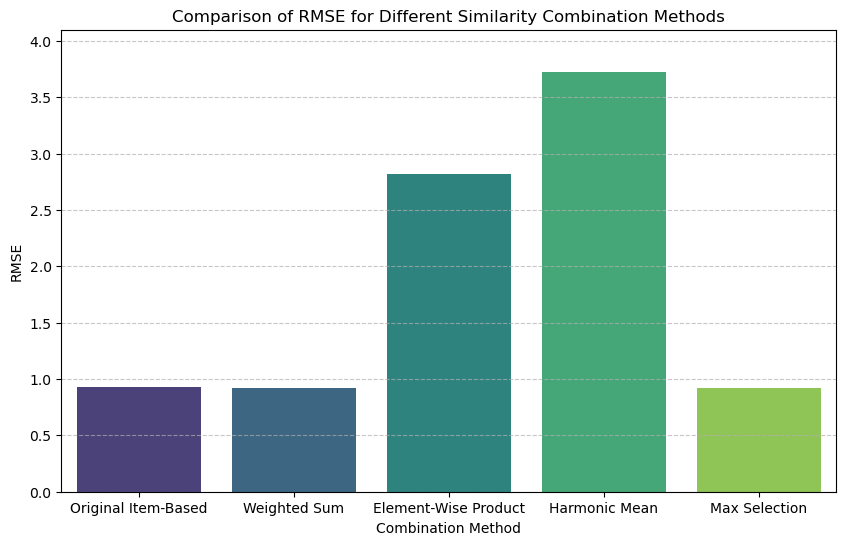

✅ RMSE 결과 시각화 완료!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(">>> 각 유사도 결합 방법의 RMSE 값 수집 및 정리 중...")

# 1. 각 유사도 결합 방법의 이름을 키로, 해당 RMSE 값을 값으로 가지는 딕셔너리 생성
rmse_results = {
    'Original Item-Based': rmse,
    'Weighted Sum': rmse_weighted_sum,
    'Element-Wise Product': rmse_element_wise_product,
    'Harmonic Mean': rmse_harmonic_mean,
    'Max Selection': rmse_max_selection
}

# 2. 생성된 딕셔너리를 Pandas DataFrame으로 변환
rmse_df = pd.DataFrame(rmse_results.items(), columns=['Combination Method', 'RMSE'])

print("✅ RMSE 결과 DataFrame 생성 완료!")
display(rmse_df)

print("\n>>> RMSE 결과 시각화 중...")

# 3. Seaborn의 barplot 함수를 사용하여 각 결합 방법의 RMSE를 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Combination Method', y='RMSE', data=rmse_df, palette='viridis')
plt.title('Comparison of RMSE for Different Similarity Combination Methods')
plt.xlabel('Combination Method')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_df['RMSE']) * 1.1) # y축 범위 조정
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 4. Matplotlib의 show() 함수를 사용하여 그래프 표시
plt.show()

print("✅ RMSE 결과 시각화 완료!")